# Project: Medical Appointment No-Show in Brazil

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

This dataset collects information from 100k medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment. A number of characteristics about the patient are included in each row. The data provided is as follows:

- `PatientId`
- `AppointmentID`
- `Gender`
- `ScheduledDay`:  day the patient set up their appointment.
- `AppointmentDay`: actual appointment date.
- `Age`
- `Neighbourhood`: location of the hospital.
- `Scholarship`: whether or not the patient is enrolled in Brasilian welfare program [Bolsa Família](https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia).
- `Hipertension`
- `Diabetes`
- `Alcoholism`
- `Handcap`
- `SMS_received`
- `No-show`: whether or not the patient showed up to the appointment (*yes* if the patient did not show)


The analysis aims to investigate the different factors (disease, time of scheduling and gender) affecting a patient's commitment to an apointment

In [1]:
# Imports
import pandas as pd               # Handling data
import matplotlib.pyplot as plt   # visuals
import numpy as np

% matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

### General Properties

In [2]:
# Load and display data
df_original = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
df = df_original.copy()
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [3]:
# General information on the datatypes in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [4]:
# Statistics on the dateset
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [5]:
# Null check
df.isnull().any()

PatientId         False
AppointmentID     False
Gender            False
ScheduledDay      False
AppointmentDay    False
Age               False
Neighbourhood     False
Scholarship       False
Hipertension      False
Diabetes          False
Alcoholism        False
Handcap           False
SMS_received      False
No-show           False
dtype: bool

In [6]:
# Duplicates check
df.duplicated().sum()

0

In [7]:
# Check for invalid entries in `No-show`
df['No-show'].unique()

array(['No', 'Yes'], dtype=object)

**Findings**

The information provided shows that the data *does not* contain any null data or duplicates  
However, the following changes need to be made:
1. `PatientId` and `AppointmentID` shall be dropped.
1. `No-show` column shall be renamed to `NoShow`, and `SMS_received` to `SmsReceived` for better code consistency.
2. Negative values shall be removed from `Age`.
3. `ScheduledDay` and `AppointmentDay` shall be changed from string to date (the exact time is less valuable).
4. A new column, `DifferenceDays` shall be added, this column contains the number of days between the reservation and the actual appointment.
5. Diseases, scholarships and no show columns shall be converted to booleans for easier manipulation and masking.


> **Observation**: while there are enteries where a patient's age exceeds 100 years, there have been incidents where individuals lived up to 115+ years. Therefore these enteries shall not be neglected.

### Data Cleaning

1. `PatientId` and `AppointmentID` shall be dropped

In [8]:
df.drop(['PatientId', 'AppointmentID'], axis=1, inplace=True)
df.columns

Index(['Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood',
       'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap',
       'SMS_received', 'No-show'],
      dtype='object')

2. `No-show` column shall be renamed to `NoShow`, and `SMS_received` to `SmsReceived` for better code consistency

In [9]:
df.rename(columns={'No-show':'NoShow', 'SMS_received':'SmsReceived'}, inplace=True)
df.columns

Index(['Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood',
       'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap',
       'SmsReceived', 'NoShow'],
      dtype='object')

3. Negative values shall be removed from `Age`

In [10]:
df = df[df['Age'] >= 0]
df['Age'].describe()

count    110526.000000
mean         37.089219
std          23.110026
min           0.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         115.000000
Name: Age, dtype: float64

3. `ScheduledDay` and `AppointmentDay` shall be changed from string to date (the exact time is less valuable)  
The string is provided with extra literals (`T` and `Z` that need cleaning)

In [11]:
# Change the datatype from string to datetime
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'], format='%Y-%m-%dT%H:%M:%SZ')
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'], format='%Y-%m-%dT%H:%M:%SZ')

df.head()

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SmsReceived,NoShow
0,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [12]:
# The table shows that AppointmentDay only has date and no time, 
#  ScheduledDay * AppointmentDay shall be converted to date only using lambda and map functions
df['ScheduledDay'] = list(map(lambda x: x.date() ,df['ScheduledDay']))
df['AppointmentDay'] = list(map(lambda x: x.date() ,df['AppointmentDay']))

type(df['ScheduledDay'][0]), type(df['AppointmentDay'][0])

(datetime.date, datetime.date)

5. A new column, `DifferenceDays` shall be added, this column contains the number of days between the reservation and the actual appointment

In [13]:
# The DifferenceDays enteries shall be changed to integers for easier manipulation
df['DifferenceDays'] = df['AppointmentDay'] - df['ScheduledDay']
df['DifferenceDays'] = list(map(lambda x: x.days, df['DifferenceDays']))
df['DifferenceDays'].describe()

count    110526.000000
mean         10.183794
std          15.255034
min          -6.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
Name: DifferenceDays, dtype: float64

In [14]:
# The description shows that there are entries where the AppointmentDay was before the ScheduledDay
#  which is not feasible. These shall be removed as well
df = df[df['DifferenceDays'] >= 0]
df['DifferenceDays'].describe()

count    110521.000000
mean         10.184345
std          15.255153
min           0.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
Name: DifferenceDays, dtype: float64

5. Diseases, scholarships and no show columns shall be converted to booleans for easier manipulation and masking.

In [15]:
# Scholarship
df['Scholarship'] = df['Scholarship'].astype(bool)

# Diseases
df['Hipertension'] = df['Hipertension'].astype(bool)
df['Diabetes'] = df['Diabetes'].astype(bool)
df['Alcoholism'] = df['Alcoholism'].astype(bool)

# SMS received
df['SmsReceived'] = df['SmsReceived'].astype(bool)

# No-Show
df['NoShow'] = df['NoShow'] == 'Yes'

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110521 entries, 0 to 110526
Data columns (total 13 columns):
Gender            110521 non-null object
ScheduledDay      110521 non-null object
AppointmentDay    110521 non-null object
Age               110521 non-null int64
Neighbourhood     110521 non-null object
Scholarship       110521 non-null bool
Hipertension      110521 non-null bool
Diabetes          110521 non-null bool
Alcoholism        110521 non-null bool
Handcap           110521 non-null int64
SmsReceived       110521 non-null bool
NoShow            110521 non-null bool
DifferenceDays    110521 non-null int64
dtypes: bool(6), int64(3), object(4)
memory usage: 7.4+ MB


<a id='eda'></a>
## Exploratory Data Analysis

### **Research Question 1:**  Do patients with certain dieases have higr rtes of No-Show?

In [16]:
# indices of handicapped patients (disregarding the type)
idx_handcap = df['Handcap'] > 0

# Percentage of no show per disease
perc_hipertension = df[df['NoShow'] & (df['Hipertension'])].shape[0] / df[df['Hipertension']].shape[0] * 100
perc_diabetes = df[df['NoShow'] & (df['Diabetes'])].shape[0] / df[df['Diabetes']].shape[0] * 100
perc_alcoholism = df[df['NoShow'] & (df['Alcoholism'])].shape[0] / df[df['Alcoholism']].shape[0] * 100
perc_handcap = df[df['NoShow'] & idx_handcap].shape[0] / df[idx_handcap].shape[0] * 100

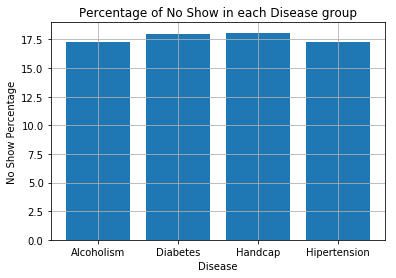

In [17]:
# Plot the information
plt.bar(['Hipertension', 'Diabetes', 'Alcoholism', 'Handcap'], 
         [perc_hipertension, perc_diabetes, perc_hipertension, perc_handcap])
plt.title('Percentage of No Show in each Disease group')
plt.grid('On')
plt.xlabel('Disease')
plt.ylabel('No Show Percentage');

>**Observation:** Despite different diseases, the variation in commiting to the appointment is minimal at best, where most patients have a chance of ~17.5% of missing their appointment

### Research Question 2: Does longer time between scheduling and appointment results increase probability of No-Show?

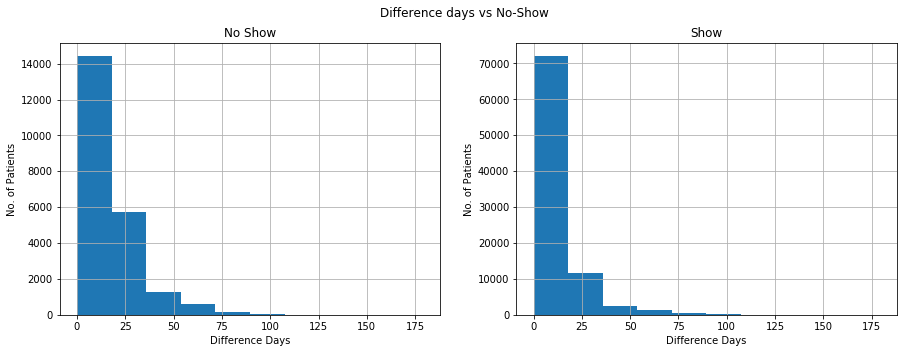

In [18]:
# Plot the distribution of difference days against show and no-show
plt.figure(figsize=(15, 5))
plt.suptitle('Difference days vs No-Show')

plt.subplot(1, 2, 1)
df[df['NoShow'] == True]['DifferenceDays'].hist()
plt.title('No Show')
plt.xlabel('Difference Days')
plt.ylabel('No. of Patients')

plt.subplot(1, 2, 2)
df[df['NoShow'] == False]['DifferenceDays'].hist()
plt.title('Show')
plt.xlabel('Difference Days')
plt.ylabel('No. of Patients');

>**Observation:** The distribution between *Show* and *No Show* does not show a meaningful correlation between the time of scheduling and actually showing up.

### Research Question 3: Does gender have a correlation with No-Show probability?

In [19]:
# Percentages for males and females
perc_male = df[df['NoShow'] & (df['Gender'] == 'M')].shape[0] / df[df['Gender'] == 'M'].shape[0]
perc_female = df[df['NoShow'] & (df['Gender'] == 'F')].shape[0] / df[df['Gender'] == 'F'].shape[0]

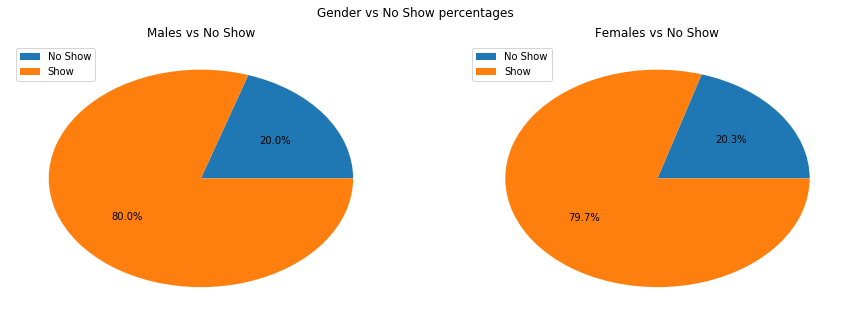

In [20]:
# Plot the percentages as pie charts
plt.figure(figsize=(15, 5))
plt.suptitle('Gender vs No Show percentages')

plt.subplot(1, 2, 1)
plt.pie([perc_male, 1-perc_male], autopct='%.1f%%')
plt.title('Males vs No Show')
plt.legend(['No Show', 'Show'])

plt.subplot(1, 2, 2)
plt.pie([perc_female, 1-perc_female], autopct='%.1f%%')
plt.title('Females vs No Show')
plt.legend(['No Show', 'Show']);

>**Observation:** There seems to be no difference in No-Show rates between males and females. They both adhere to a No-Show rate of 20%.

<a id='conclusions'></a>
## Conclusions

This report aimed to investigate the correlation of 3 factors on the No-Show probability to medical appointments. the factors investigated were:
- Type of disease of the patient
- Time between scheduling an appointment and the actual appointment date
- Gender

The results conclude that there is no correlation between any of the aforementioned factors and the No-Show probability.

#### Limitations

- The invalid enteries in the original dataset are very minimal, therefore posing no limitation on the accuracy of the colelcted data.

- The age distribution is inline with the general demographics of Brazil for the same year (2016), as per the image below. (source: [wikipedia](https://commons.wikimedia.org/wiki/File:Population_pyramid_of_Brazil_2016.png))

- The gender distribution for the dataset shows a bias towards females, however the actual distribution shows that the ratio is closer to 50/50 between males and females in 2016 (males: 101.45 millions, females: 104.71 millions), which might impose a limitation on how the sample can be generalized to the population of Brazil. (source: [statista](https://www.statista.com/statistics/788353/population-total-gender-brazil/#:~:text=Brazil%3A%20total%20population%202008%2D2018%2C%20by%20gender&text=In%202018%2C%20the%20total%20population,in%20this%20Latin%20American%20country.))

<img src="https://upload.wikimedia.org/wikipedia/commons/b/b3/Population_pyramid_of_Brazil_2016.png">

In [21]:
# Number of invalid enteries
invalid_enteries = (df_original.shape[0] - df.shape[0])
invalid_enteries_perc = (invalid_enteries / df_original.shape[0]) * 100

print("There were %d invalid enteries, accounting to %.3f%% of the size of the original dataset." 
      % (invalid_enteries, invalid_enteries_perc))

There were 6 invalid enteries, accounting to 0.005% of the size of the original dataset.


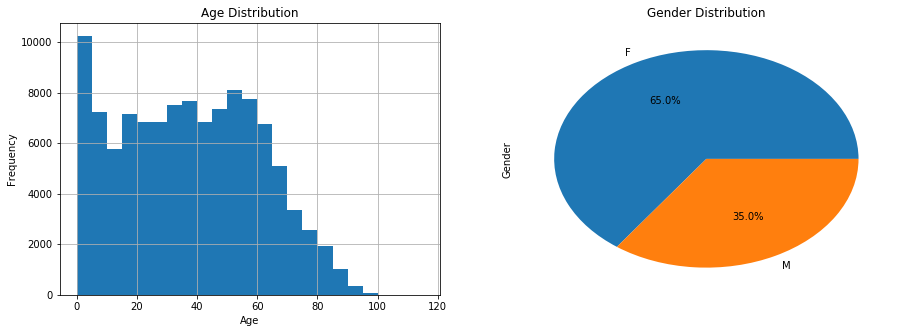

In [22]:
# Age and gender distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
df['Age'].hist(bins=np.arange(0, 120, 5))
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')

plt.subplot(1, 2, 2)
df['Gender'].value_counts().plot(kind='pie', autopct='%.1f%%')
plt.title('Gender Distribution');

#### Further steps

Given the dataset provided, other factors could also be investigated, namely the age of the patient and the location of the hospital.

In [23]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0